### TSSOS fails to find traceless disipator which exists

In [56]:
include("LiPoSID.jl")
using QuantumOptics
basis = NLevelBasis(2)
using DynamicPolynomials
using Plots
using JuMP
using NLopt

Consider simplest possible Lindblad master equation with just one dissipator:

$
     \frac{d\rho}{dt} = - \frac{i}{\hbar}[H, \rho]+\left[A \rho A^\dagger - \frac{1}{2}\left\{ A^\dagger A, \rho \right\} \right]
$,

where Hamiltonian is hermitian with one of the diagonal elemnets set to zero


$
    H = \begin{pmatrix} e_1 & h_1 - i h_2 \\ h_1 + i h_2 & 0
   \end{pmatrix}
$

and dissipator is traceless:

$
A = \begin{pmatrix} a_1 + i b_1 &   a_2 + i b_2\\  a_3 + i b_3 & - a_1 - i b_1
   \end{pmatrix} $
   
$ \operatorname{tr} A = 0$




### Load exact data

In [2]:
γᵗˣᵗ = "0.079477"

parentdir = pwd()
data_dir = parentdir*"\\DATA\\"
println(data_dir)

ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γᵗˣᵗ)
ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γᵗˣᵗ)
ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γᵗˣᵗ)
ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γᵗˣᵗ)

@assert tᵍ == tᵉ == tˣ == tʸ 

t = convert(Vector{Float64}, tᵉ)
@assert maximum(diff(t)) ≈ minimum(diff(t)) ≈ t[2]-t[1]
Δt = t[2]-t[1]
t_steps = length(t)

C:\Users\Zakhar\Documents\GitHub\POP_fail\DATA\


1256

### Perform POP SID

In [107]:
#using DynamicPolynomials

@polyvar e[1:2]
@polyvar h[1:2]

Hˢʸᵐᵇₐₙ = [ e[1]   0
            0    0. ]

Hˢʸᵐᵇ = [ e[1]               h[1] - im*h[2]
          h[1] + im*h[2]     0.             ]

2×2 Matrix{Polynomial{true, ComplexF64}}:
 e₁                  h₁ + (0.0-1.0im)h₂
 h₁ + (0.0+1.0im)h₂  0.0+0.0im

In [108]:
@polyvar a[1:3]
@polyvar b[1:3]

Aˢʸᵐᵇₐₙ = [ 0      a[2]
            0     0.  ]

#Aˢʸᵐᵇₐₙ = [ 0       a[2]
#            a[1]     0.  ]

Aˢʸᵐᵇ = [ a[1] + im*b[1]           a[2] + im*b[2]
          a[3] + im*b[3]          -a[1] - im*b[1]   ]

2×2 Matrix{Polynomial{true, Complex{Int64}}}:
 a₁ + (0+1im)b₁  a₂ + (0+1im)b₂
 a₃ + (0+1im)b₃  -a₁ + (0-1im)b₁

In [109]:
objₑₓ = 0
objₑₓₐₙ = 0

for ρ in [ρᵍ, ρᵉ, ρˣ, ρʸ]

    # Convert cut ρ series:
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)

    objₑₓ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇ])
    
    objₑₓₐₙ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇₐₙ, [Aˢʸᵐᵇₐₙ])

end # of files (initial states) loop

In [21]:
objₑₓₐₙ

1.6697789826640932a₂⁴ + 3.3395579653281864a₂²b₂² + 1.6697789826640932b₂⁴ - 0.26545473091539a₂² - 0.26545473091539b₂² + 0.024491701652818016

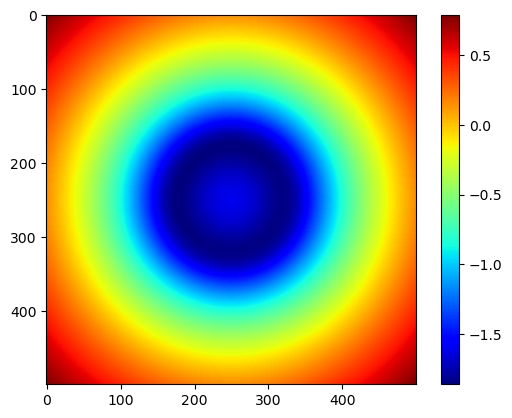

In [40]:
using PyPlot
x = range(-1,1,500)
reg = objₑₓₐₙ + 0.01 * (a[2]^3+b[2]^3)
imshow(log10.(abs.(reg.(x,x'))), cmap="jet")
colorbar()
show()

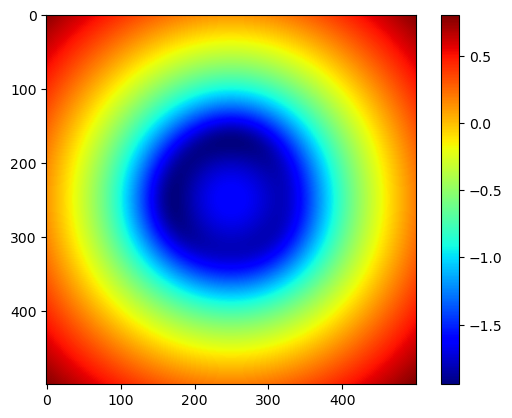

In [36]:
using PyPlot
x = range(-1,1,500)
reg = objₑₓₐₙ + 0.1(a[2]^3+b[2]^3)
imshow(log10.(abs.(reg.(x,x'))), cmap="jet")
colorbar()
show()

In [121]:
solₑₓₐₙⁿᵉʷ, best_methodₑₓₐₙⁿᵉʷ = LiPoSID.sos_min_newton(objₑₓₐₙ) 
@show subs(objₑₓₐₙ, solₑₓₐₙⁿᵉʷ)
Hₑₓₐₙ = subs(Hˢʸᵐᵇₐₙ, solₑₓₐₙⁿᵉʷ)
Aₑₓₐₙ = subs(Aˢʸᵐᵇₐₙ, solₑₓₐₙⁿᵉʷ)

************************TSSOS************************
TSSOS is launching...
optimum = 0.0013068260669271202
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 0.0013068175921014087
Found a local optimal solution giving an upper bound: 0.011857047039541158 and a relative optimality gap: 0.01055022944743975.
No higher TSSOS hierarchy!
val_p = [0.0013068163059983817, 0.011857047039598001]
subs(objₑₓₐₙ, solₑₓₐₙⁿᵉʷ) = 0.0013068163059983817


2×2 Matrix{Term{true, Float64}}:
 0.0  0.281936
 0.0  0.0

In [111]:
Hₑₓₐₙ 

2×2 Matrix{Term{true, Float64}}:
 25.1261  0.0
 0.0      0.0

In [ ]:


function g(a...)
# Converting polynomial expression of objective to function to be minimized
obj(vars => a)
end

In [122]:
solₑₓⁿᵉʷ, best_methodₑₓⁿᵉʷ = LiPoSID.sos_min_newton(objₑₓ + 0.01 * sum(a.^3 + b.^3) ) 
@show subs(objₑₓ, solₑₓⁿᵉʷ)
Hˢⁱᵈₑₓ = subs(Hˢʸᵐᵇ, solₑₓⁿᵉʷ)
Aˢⁱᵈₑₓ = subs(Aˢʸᵐᵇ, solₑₓⁿᵉʷ)

************************TSSOS************************
TSSOS is launching...
optimum = 0.00029536331344672017
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 0.0002952547386960273
Global optimality certified!
No higher TSSOS hierarchy!
val_p = [0.0002952605359496374, 0.000295260535892794]
subs(objₑₓ, solₑₓⁿᵉʷ) = 0.0005538178422170859


2×2 Matrix{Polynomial{true, ComplexF64}}:
 (3.62325e-5-7.53159e-7im)  (-0.294549+0.000207066im)
 (-0.0669974-0.00427836im)  (-3.62325e-5+7.53159e-7im)

In [126]:
@show subs(objₑₓₐₙ, solₑₓₐₙⁿᵉʷ)
@show subs(objₑₓ, solₑₓⁿᵉʷ)
@show subs(objₑₓ, solloc)

subs(objₑₓₐₙ, solₑₓₐₙⁿᵉʷ) = 0.0013068163059983817
subs(objₑₓ, solₑₓⁿᵉʷ) = 0.0005538178422170859
subs(objₑₓ, solloc) = 0.0005504405390297507


0.0005504405390297507

In [60]:
solₑₓⁿᵉʷ[2]

9-element Vector{Float64}:
 25.12610353253209
  4.42439410542523e-5
  3.759278738687498e-5
  3.623254451153561e-5
 -0.2945494391560584
 -0.0669973962482459
 -7.531586440474703e-7
  0.0002070663111225228
 -0.004278358783321587

In [78]:
sollocreg = local_min(objₑₓ+ 0.01 * sum(a.^3 + b.^3), rand(length(variables(objₑₓ))))

PolyVar{true}[e₁, h₁, h₂, a₁, a₂, a₃, b₁, b₂, b₃] => [25.126103541147465, 4.4382347336635524e-5, 3.760091273166925e-5, 5.964953955025046e-7, -0.00023515749401656596, 0.004269282079309037, 3.600081469386578e-5, -0.29454932874258494, -0.06699756770829228]

In [79]:
subs(Aˢʸᵐᵇ, sollocreg )

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (5.96495e-7+3.60008e-5im)  (-0.000235157-0.294549im)
 (0.00426928-0.0669976im)   (-5.96495e-7-3.60008e-5im)

In [123]:
solloc = local_min(objₑₓ, solₑₓⁿᵉʷ[2])  

PolyVar{true}[e₁, h₁, h₂, a₁, a₂, a₃, b₁, b₂, b₃] => [25.126102673347184, 4.439601127200425e-5, 3.800607231407631e-5, 3.6916442093249125e-5, -0.2920099404177209, -0.0657129191308621, -2.1374939185787908e-6, 0.0002105221359248663, -0.004219239071999739]

In [124]:
@show subs(objₑₓ, solloc)

subs(objₑₓ, solloc) = 0.0005504405390297507


0.0005504405390297507

In [63]:
Aloc = subs(Aˢʸᵐᵇ, solloc )

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (3.69164e-5-2.13749e-6im)  (-0.29201+0.000210522im)
 (-0.0657129-0.00421924im)  (-3.69164e-5+2.13749e-6im)

In [64]:
Aˢⁱᵈₑₓ

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (3.62325e-5-7.53159e-7im)  (-0.294549+0.000207066im)
 (-0.0669974-0.00427836im)  (-3.62325e-5+7.53159e-7im)

In [80]:
ρˣˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρˣ[1], t, Hˢⁱᵈₑₓ, [Aˢⁱᵈₑₓ]);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360


In [68]:
f = LiPoSID.fidelity_series(basis, ρˣ, ρˣˢⁱᵈ);

In [70]:
minimum(f)

0.9957628626040526

In [ ]:
minimum(LiPoSID.fidelity_series(basis, ρˣ, ρˣˢⁱᵈ))

In [51]:
subs(objₑₓ, solₑₓⁿᵉʷ)

0.0005538178422170859

In [104]:
sqrt(0.079477)

0.28191665435018204

In [114]:
#Aˢⁱᵈₑₓ = subs(Aˢʸᵐᵇ, solₑₓⁿᵉʷ )

Aˢⁱᵈₑₓ = [ 0  sqrt(0.079477) #0.281936  
           0  0         ]

@show Aˢⁱᵈₑₓ


#Hˢⁱᵈₑₓ = subs(Hˢʸᵐᵇ, solₑₓⁿᵉʷ )

Hˢⁱᵈₑₓ  = [25.1261   0
            0        0. ]

@show Hˢⁱᵈₑₓ


F = []

test_files = ["State_D"*string(n) for n=1:20]
    
γᵢᵗˣᵗ = "0.079477"


for df in test_files # loop over initial states

    print(df*" ")

    # Read EXACT data series of Kurt data

    ρ, t = LiPoSID.get_rho_series(data_dir*df*"_2CUT_data.h5", string(γᵢᵗˣᵗ))

    ρₑₓ = convert(Vector{Matrix{ComplexF64}}, ρ)
    t = convert(Vector{Float64}, t)

    # Restore data series POP identified

    ρ₀ = ρₑₓ[1]

    ρₑₓʳᵉᵍ = LiPoSID.Lindblad_time_evolution(basis, ρ₀, t, Hˢⁱᵈₑₓ, [Aˢⁱᵈₑₓ])


    # Calculating fidelity series

    max_step = max(length(ρₑₓ), length(ρₑₓʳᵉᵍ))
        
    f = LiPoSID.fidelity_series(basis, ρₑₓ[1:max_step], ρₑₓʳᵉᵍ[1:max_step])
    
    push!(F,convert.(Float64, f))

    @show minimum(f)

end # of files (initial states) df loop

Aˢⁱᵈₑₓ = [0.0 0.28191665435018204; 0.0 0.0]
Hˢⁱᵈₑₓ = [25.1261 0.0; 0.0 0.0]
State_D1 minimum(f) = 0.999366901320202
State_D2 minimum(f) = 0.999370145020415
State_D3 minimum(f) = 0.9993699947341442
State_D4 minimum(f) = 0.9993716897468259
State_D5 minimum(f) = 0.9991841256297062
State_D6 minimum(f) = 0.999184111284191
State_D7 minimum(f) = 0.9990496153484396
State_D8 minimum(f) = 0.999050885747791
State_D9 minimum(f) = 0.9998454982466516
State_D10 minimum(f) = 0.9998785604389427
State_D11 minimum(f) = 0.9993699858838774
State_D12 minimum(f) = 0.9993716866960474
State_D13 minimum(f) = 0.9993668573377696
State_D14 minimum(f) = 0.9993701248311082
State_D15 minimum(f) = 0.999184706215906
State_D16 minimum(f) = 0.9991846677794888
State_D17 minimum(f) = 0.9990495995350394
State_D18 minimum(f) = 0.9990508808611911
State_D19 minimum(f) = 0.9998785651435265
State_D20 minimum(f) = 0.9998454754014731


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

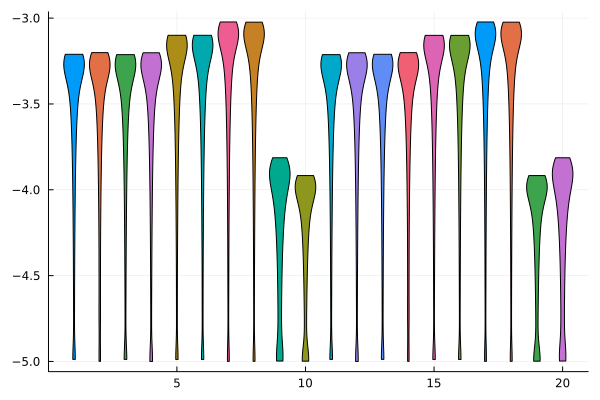

In [116]:
lf = [ log10.(abs.(1 .- f )) for f in F]

for i in 1:length(lf)
    lf[i][lf[i] .< -5] .= -5
end

violin(lf, labels="")

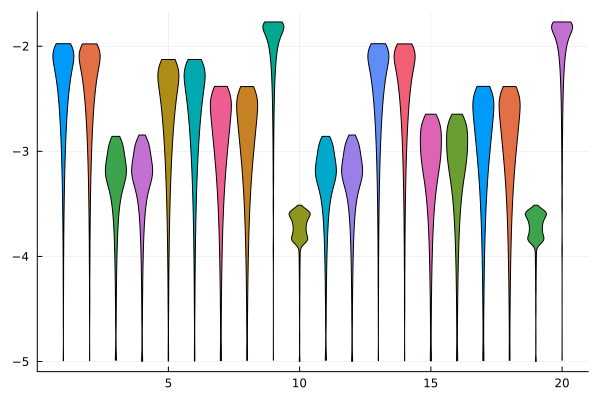

In [102]:
lf = [ log10.(abs.(1 .- f )) for f in F]

for i in 1:length(lf)
    lf[i][lf[i] .< -5] .= -5
end

violin(lf, labels="")

In [128]:
#Aˢⁱᵈₑₓ = subs(Aˢʸᵐᵇ, solₑₓⁿᵉʷ )

Aˢⁱᵈₑₓ = [ 0  sqrt(0.079477) #0.281936  
           0  0         ]

@show Aˢⁱᵈₑₓ


#Hˢⁱᵈₑₓ = subs(Hˢʸᵐᵇ, solₑₓⁿᵉʷ )

Hˢⁱᵈₑₓ  = [25.1261   0
            0        0. ]

@show Hˢⁱᵈₑₓ


F = []

    
γᵢᵗˣᵗ = "0.079477"

df = "State_D20"

ρ, t = LiPoSID.get_rho_series(data_dir*df*"_2CUT_data.h5", string(γᵢᵗˣᵗ))
ρₑₓ = convert(Vector{Matrix{ComplexF64}}, ρ)
t = convert(Vector{Float64}, t)

# Restore data series POP identified

ρ₀ = ρₑₓ[1]
ρₑₓʳᵉᵍ = LiPoSID.Lindblad_time_evolution(basis, ρ₀, t, Hˢⁱᵈₑₓ, [Aˢⁱᵈₑₓ])

bₑₓʳᵉᵍ = LiPoSID.bloch(ρₑₓʳᵉᵍ)

bₑₓʳᵉᵍ = LiPoSID.bloch(ρₑₓʳᵉᵍ)

function xyz(b)
    x = b[1,:]
    y = b[2,:]
    z = b[3,:]
    return x,y,z
end



Aˢⁱᵈₑₓ = [0.0 0.28191665435018204; 0.0 0.0]
Hˢⁱᵈₑₓ = [25.1261 0.0; 0.0 0.0]


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360


xyz (generic function with 1 method)

In [130]:
b

3×1256 Matrix{Float64}:
 -0.02286    0.150977   0.287236  …   0.125886   0.128542  0.0994359
 -0.35531   -0.322137  -0.209429     -0.0380397  0.027273  0.0857438
  0.932036   0.932144   0.932252      0.990725   0.99074   0.990755

In [132]:
Plots.plotlyjs()
plt = Plots.plot(b...)

LoadError: Couldn't process recipe args: (Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64)

In [127]:
F[20]

1256-element Vector{Float64}:
 0.9999999999999997
 0.9999991930185756
 0.9999998294280005
 0.9999983361015335
 0.9999890756107895
 0.9999766450459602
 0.9999724701583909
 0.9999774837049632
 0.9999837493135721
 0.9999873231403519
 0.9999892622361285
 0.99999183621588
 0.9999952763314984
 ⋮
 0.9998494916802078
 0.9998484502580053
 0.9998467903843558
 0.9998466309808298
 0.9998486900757994
 0.9998513491743218
 0.9998522027128666
 0.999850734900205
 0.9998489751582751
 0.9998493523865429
 0.9998521547647897
 0.9998549936029955

In [92]:
using StatsPlots

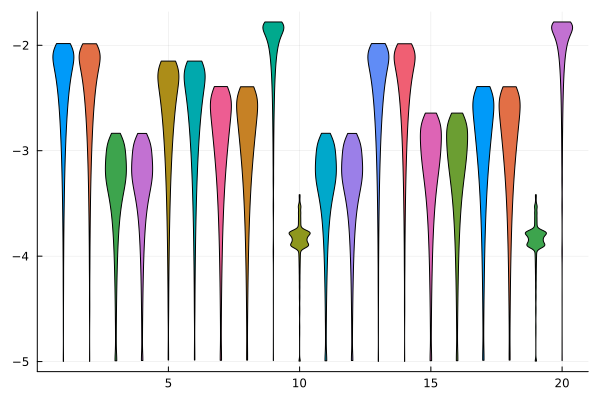

In [100]:
lf = [ log10.(abs.(1 .- f )) for f in F]

for i in 1:length(lf)
    lf[i][lf[i] .< -5] .= -5
end

violin(lf, labels="")

In [8]:
best_methodₑₓⁿᵉʷ

"scaled_tssos"

In [52]:
Aˢⁱᵈₑₓ

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (3.62325e-5-7.53159e-7im)  (-0.294549+0.000207066im)
 (-0.0669974-0.00427836im)  (-3.62325e-5+7.53159e-7im)

All the elements of dissipator $A$ are zero!!!

In [53]:
Hˢⁱᵈₑₓ

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (25.1261+0.0im)            (4.42439e-5-3.75928e-5im)
 (4.42439e-5+3.75928e-5im)  0.0+0.0im

But we can find non-zero dissipator $A$ if look for 

$
    H = \begin{pmatrix} e_1 & 0 \\ 0 & 0
   \end{pmatrix}
$


$
A = \sqrt{\gamma} \sigma = \begin{pmatrix} 0 & a \\ 0 & 0
   \end{pmatrix}$

In [42]:
solₑₓₐₙⁿᵉʷ, best_methodₑₓₐₙⁿᵉʷ = LiPoSID.sos_min_newton(reg) 
Hˢⁱᵈₑₓₐₙ = subs(Hˢʸᵐᵇₐₙ, solₑₓₐₙⁿᵉʷ)
Aˢⁱᵈₑₓₐₙ = subs(Aˢʸᵐᵇₐₙ, solₑₓₐₙⁿᵉʷ)

************************TSSOS************************
TSSOS is launching...
optimum = 0.013714666202838286
Global optimality certified!
optimum = 0.013714666227094129
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 0.013714663377965933
Global optimality certified!
optimum = 0.0137146622261574
Global optimality certified!
No higher TSSOS hierarchy!
val_p = [0.013781658076890621, 0.013781658076890631]


2×2 Matrix{Polynomial{true, ComplexF64}}:
 0.0+0.0im  (-0.200485-0.200485im)
 0.0+0.0im  0.0+0.0im

In [43]:
subs(objₑₓ, solₑₓⁿᵉʷ), subs(objₑₓₐₙ, solₑₓₐₙⁿᵉʷ)

LoadError: UndefVarError: solₑₓⁿᵉʷ not defined

In [44]:
Hˢⁱᵈₑₓₐₙ

2×2 Matrix{Float64}:
 25.0  0.0
  0.0  0.0

In [45]:
Aˢⁱᵈₑₓₐₙ

2×2 Matrix{Polynomial{true, ComplexF64}}:
 0.0+0.0im  (-0.200485-0.200485im)
 0.0+0.0im  0.0+0.0im

In [46]:
abs(-0.200485-0.200485im)

0.28352860605236996

Difference is 12 orders of magnitude

### Try to zero diagonal and it works

In [15]:
Aˢʸᵐᵇ₀ = [ 0                 a[2] + im*b[2]
          a[3] + im*b[3]     0              ]

2×2 Matrix{Polynomial{true, Complex{Int64}}}:
 0+0im           a₂ + (0+1im)b₂
 a₃ + (0+1im)b₃  0+0im

In [41]:
obj₀ = 0

for ρ in [ρᵍ, ρᵉ, ρˣ, ρʸ]

    # Convert cut ρ series:
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)

    obj₀ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇ₀])


end # of files (initial states) loop

obj₀ 

LoadError: UndefVarError: Aˢʸᵐᵇ₀ not defined

In [17]:
sol₀ , best_method₀  = LiPoSID.sos_min_newton(obj₀ ) 
H₀  = subs(Hˢʸᵐᵇ, sol₀ )
A₀  = subs(Aˢʸᵐᵇ₀, sol₀ )

************************TSSOS************************
TSSOS is launching...
optimum = 0.0005505608156240852
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 0.0005504360651199577
Global optimality certified!
No higher TSSOS hierarchy!
val_p = [0.0005504409853074321, 0.0005504409852505887]


2×2 Matrix{Polynomial{true, ComplexF64}}:
 0.0+0.0im                (0.207045+0.205918im)
 (0.0435801+0.0493635im)  0.0+0.0im

but finds other dissipator that in theory should be unigue 

In [18]:
subs(obj₀, sol₀), subs(objₑₓ, solₑₓⁿᵉʷ), subs(objₑₓₐₙ, solₑₓₐₙⁿᵉʷ)

(0.0005504409851937453, 0.01185694330882825, 0.0013068163059983817)

In [19]:
H₀

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (25.1261+0.0im)            (4.51489e-5-4.14822e-5im)
 (4.51489e-5+4.14822e-5im)  0.0+0.0im

In [21]:
rand((10))

10-element Vector{Float64}:
 0.2217654824270231
 0.986016258251388
 0.024999404675070336
 0.7055673879821943
 0.18595392508465014
 0.1838418664668251
 0.18524007931148667
 0.8199221113712533
 0.8920935788959723
 0.7135931502410234

In [57]:
function local_min(obj, guess)  
    
    vars = variables(obj)

    #obj += 0.1 * sum(b.^4 + a.^4 + b.^3 + a.^3 )

    #best_sol = rand((length(vars)))*10 .- 5
    
    function g(a...)
    # Converting polynomial expression of objective to function to be minimized
    obj(vars => a)
    end

    # Create NLopt model
    model = Model(NLopt.Optimizer)

    # Set algorithm 
    set_optimizer_attribute(model, "algorithm", :LD_SLSQP) 

    # Set variables
    @variable(model, y[1:length(vars)]);

    # Register objective
    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))

    # Set guess

    for (var, init_val) in zip(y, guess)
        set_start_value(var, init_val)
    end

    # Call JuMP optimization function
    JuMP.optimize!(model)

    solution = vars => map(value, y)

    return solution

end

local_min (generic function with 1 method)

In [61]:
using JuMP
using NLopt

function local_min(obj)
    
    
    
    vars = variables(obj)

    obj += 0.1 * sum(b.^4 + a.^4 + b.^3 + a.^3 )
    
    best_sol = ones(length(vars))
    
    #best_sol = rand((length(vars)))*10 .- 5
    
    function g(a...)
    # Converting polynomial expression of objective to function to be minimized
    obj(vars => a)
    end

    # Create NLopt model
    model = Model(NLopt.Optimizer)

    # Set algorithm 
    set_optimizer_attribute(model, "algorithm", :LD_SLSQP) 

    # Set variables
    @variable(model, y[1:length(vars)]);

    # Register objective
    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))

    # Set guess
    guess = best_sol

    for (var, init_val) in zip(y, guess)
        set_start_value(var, init_val)
    end

    # Call JuMP optimization function
    JuMP.optimize!(model)

    solution = vars => map(value, y)

    return solution

end


local_min (generic function with 1 method)

In [62]:
sol = local_min(objₑₓ)

PolyVar{true}[e₁, h₁, h₂, a₁, a₂, a₃, b₁, b₂, b₃] => [25.126108554683263, 4.362205902539824e-5, 3.545721837732338e-5, 3.4062653604499794e-5, -0.30758489596417354, -0.07443658769201285, 6.06445157104174e-6, 0.00037102019930264254, -0.004441926997253978]

In [63]:
sum(variables(objₑₓ) .^ 2)

e₁² + h₁² + h₂² + a₁² + a₂² + a₃² + b₁² + b₂² + b₃²

In [64]:
Hl  = subs(Hˢʸᵐᵇ, sol )


2×2 Matrix{Polynomial{true, ComplexF64}}:
 (25.1261+0.0im)            (4.36221e-5-3.54572e-5im)
 (4.36221e-5+3.54572e-5im)  0.0+0.0im

In [65]:
Al  = subs(Aˢʸᵐᵇ₀, sol )

2×2 Matrix{Polynomial{true, ComplexF64}}:
 0.0+0.0im                  (-0.307585+0.00037102im)
 (-0.0744366-0.00444193im)  0.0+0.0im

In [66]:
subs(objₑₓ, sol)

0.000683983012322642

In [60]:
subs(obj₀, sol₀), subs(objₑₓ, solₑₓⁿᵉʷ), subs(objₑₓₐₙ, solₑₓₐₙⁿᵉʷ)

(0.0005504409851937453, 0.01185694330882825, 0.0013068163059983817)

In [ ]:
ρˣₑₓˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρˣ[1], t, Hˢⁱᵈₑₓ, [Lˢⁱᵈₑₓ])